In [2]:
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geneclusters.cluster_genes import score_for_thres, get_kernighan_lin_clusters
from geneclusters.prepare_inputs import get_gene_pathway_matrix
from geneclusters.compute_stats import compute_t, compute_permuted_t, return_correlation_matrix, return_permutation_inputs, run_permutations, compute_permutation_p
from geneclusters.plotting import plot_permutations

cpu = multiprocessing.cpu_count()
pool = multiprocessing.Pool(cpu-1)

Process ForkPoolWorker-80:
Process ForkPoolWorker-73:
Process ForkPoolWorker-78:
Process ForkPoolWorker-64:
Process ForkPoolWorker-82:
Process ForkPoolWorker-57:
Process ForkPoolWorker-67:
Process ForkPoolWorker-87:
Process ForkPoolWorker-65:
Process ForkPoolWorker-72:
Process ForkPoolWorker-49:
Process ForkPoolWorker-85:
Process ForkPoolWorker-70:
Process ForkPoolWorker-68:
Process ForkPoolWorker-52:
Process ForkPoolWorker-60:
Process ForkPoolWorker-54:
Process ForkPoolWorker-56:
Process ForkPoolWorker-88:
Process ForkPoolWorker-93:
Process ForkPoolWorker-84:
Process ForkPoolWorker-90:
Process ForkPoolWorker-75:
Process ForkPoolWorker-50:
Process ForkPoolWorker-91:
Process ForkPoolWorker-66:
Process ForkPoolWorker-81:
Process ForkPoolWorker-35:
Process ForkPoolWorker-76:
Process ForkPoolWorker-45:
Process ForkPoolWorker-46:
Process ForkPoolWorker-44:
Process ForkPoolWorker-28:
Process ForkPoolWorker-94:
Process ForkPoolWorker-42:
Process ForkPoolWorker-39:
Process ForkPoolWorker-61:
P

In [3]:
# run with internet
import gseapy
import numpy as np
x = gseapy.get_library('WikiPathway_2021_Human')
np.save('WikiPathway_2021_Human.npy', x)


KeyboardInterrupt



In [ ]:
# assign the clusters
frame = get_kernighan_lin_clusters('./examples/WikiPathway_2021_Human.npy', threshold=50, C=.5)
frame.columns = ['cluster', 'description', 'is_gene']
frame.to_csv('kernighan_clusters.csv', index = False)

** Ex **


  0%|          | 0/5 [00:00<?, ?it/s]

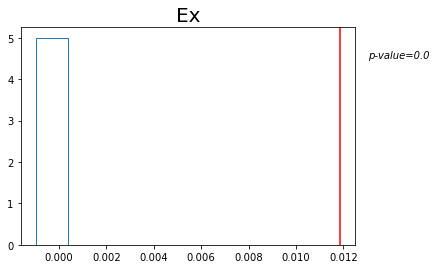

In [4]:
# evaluate observed correlations against Null
frame = pd.read_csv('kernighan_clusters.csv')
Nperm = 5

for name in np.array(['Ex']):#, 'In', 'Mic', 'Ast', 'Oli', 'Opc']):
    print('** '+name+' **')
    permuted_t, observed_t = run_permutations('./examples/' + name +'.csv', frame, Nperm)
    p = compute_permutation_p(permuted_t, observed_t)
    plot_permutations(permuted_t, observed_t, p, Nperm, name)
    plt.show()